In [1]:
import scanpy as sc
import scirpy as ir

from genevector.data import GeneVectorDataset
from genevector.model import GeneVector
from genevector.embedding import GeneEmbedding, CellEmbedding

import tcri

ImportError: cannot import name 'clonotypic_entropy' from 'tcri.metrics._metrics' (/Users/ceglian/miniconda3/lib/python3.9/site-packages/tcri-0.0.1-py3.9.egg/tcri/metrics/_metrics.py)

In [ ]:
adata = ir.datasets.wu2020_3k()

In [ ]:
sc.pp.filter_genes(adata, min_cells=10)
sc.pp.filter_cells(adata, min_genes=100)
sc.pp.highly_variable_genes(adata, flavor="seurat_v3", n_top_genes=1000, subset=True) #works on raw counts

In [ ]:
dataset = GeneVectorDataset(adata)

In [ ]:
# cmps = GeneVector(dataset,
#                   output_file="wu2020_3k.vec",
#                   batch_size=200000,
#                   initial_lr=0.1,
#                   threshold=1e-5,
#                   emb_dimension=100)

In [ ]:
# %%capture
# cmps.train(5000)

In [ ]:
embed = GeneEmbedding("wu2020_3k.vec", dataset,vector="average")
print(embed.compute_similarities("CD8A").head(20))

In [ ]:
cembed = CellEmbedding(dataset, embed)
adata = cembed.get_adata()

In [ ]:
import pandas
markers = cembed.get_predictive_genes(adata,"cluster_orig",n_genes=10)
pandas.DataFrame.from_dict(markers).T

In [ ]:
adata = cembed.phenotype_probability(adata,markers)

In [ ]:
sc.pl.umap(adata,color=["genevector","cluster_orig"],wspace=0.5)

In [ ]:
cembed.plot_confusion_matrix(adata,"genevector","cluster_orig")

In [ ]:
sample_column="sample"
condition_column="source"
phenotype_column="genevector"

tcri.pp.joint_distribution(adata,
                           sample_column=sample_column, 
                           condition_column=condition_column, 
                           phenotype_column=phenotype_column)

['CASSYQGATEAFF',
 'CASTLTGGLDTEAFF',
 'CASSGGYYNEQFF',
 'CASSIDGPGTSVWSSYNEQFF',
 'CASSPGTSVREQYF',
 'CASSFRGTGELFF',
 'CASSYGLSWGSYEQYF',
 'CASSLASGMNTEAFF',
 'CASSRTGGDSGELFF']

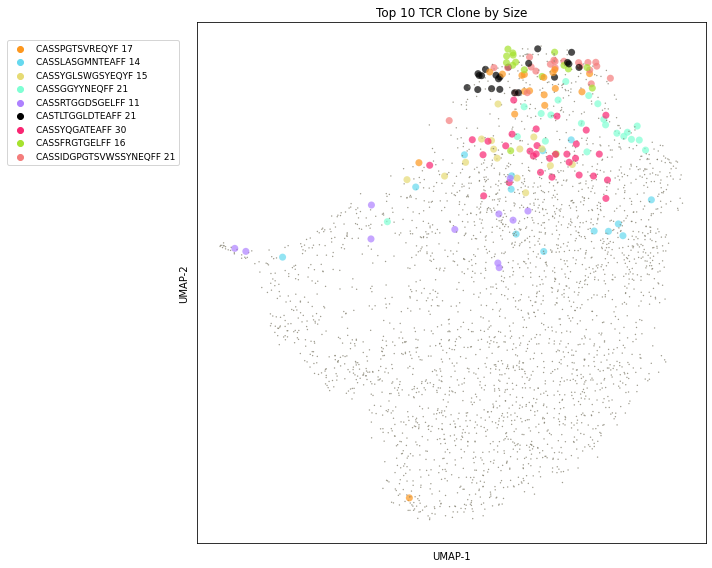

In [14]:
tcri.pl.tcr_umap(adata)

/Users/ceglian/miniconda3/lib/python3.9/site-packages/tcri-0.0.1-py3.9.egg/tcri/metrics/_metrics.py:25: RuntimeWarning: invalid value encountered in double_scalars


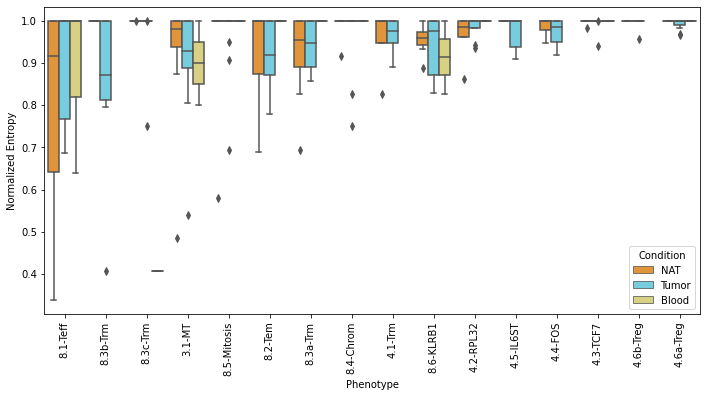

In [15]:
tcri.pl.phenotypic_entropy(adata)

In [18]:
import matplotlib
import pandas
matplotlib.rcParams['svg.fonttype'] = "none"
import numpy
import pandas 
import collections
import matplotlib.pyplot as plt
import seaborn as sns

# def calc_entropy(P, log_units = 2):
#     P = P[P>0].flatten()
#     return numpy.dot(P, -numpy.log(P)) / numpy.log(log_units)

# def phenotypic_entropy(adata):
#     prob_cols = []
#     for x in adata.obs.columns:
#         if "Pseudo-probability" in x:
#             prob_cols.append(x)
#     df = adata.obs
#     clonotype_dist = collections.defaultdict(list)
#     for c in set(df[adata.uns["clonotype_column"]]):
#         dfx = df[df[adata.uns["clonotype_column"]]==c]
#         X = dfx[prob_cols]
#         X /= X.sum(axis=0)
#         dist = X.to_numpy()[0]
#         clonotype_dist[c] = dist
#     clonotype_expected_cells = dict()
#     total_sum = 0
#     for clone, ps in clonotype_dist.items():
#         clonotype_expected_cells[clone] = sum(ps)
#         total_sum += sum(ps)
#     phenotype_entropy = []
#     for clone, psum in clonotype_expected_cells.items():
#         phenotype_entropy.append(psum/total_sum)
#     return calc_entropy(numpy.array(phenotype_entropy))  / numpy.log2(total_sum)

# def plot_phenotypic_entropy(adata, title=""):
#     entropies = []
#     phenotypes = []
#     samples = []
#     conditions = []
#     phenotypes = []
#     for s in set(adata.obs[adata.uns["sample_column"]]):
#         sub = adata[adata.obs[adata.uns["sample_column"]]==s]
#         for c in set(sub.obs[sub.uns["condition_column"]]):
#             cdata = sub[sub.obs[sub.uns["condition_column"]]==c]
#             for ph in adata.uns["phenotype_order"]:
#                 pdata = cdata[cdata.obs[adata.uns["phenotype_column"]]==ph]
#                 ent = phenotypic_entropy(pdata)
#                 entropies.append(1-ent)
#                 phenotypes.append(ph)
#                 samples.append(s)
#                 conditions.append(c)
#     df = pandas.DataFrame.from_dict({"Sample":samples,
#                                      "Condition":conditions,  
#                                      "Phenotype":phenotypes,
#                                      "Normalized Entropy":entropies})
#     df = df.sort_values("Normalized Entropy")
#     fig, ax = plt.subplots(1,1,figsize=(10,3))
#     sns.boxplot(data=df,x="Phenotype",y="Normalized Entropy",hue="Condition",ax=ax)
#     plt.tight_layout()
#     ax.set_title(title)
#     ax.set_xticklabels(ax.get_xticklabels(),rotation=90)
#     return df

In [139]:
phenotypic_entropy(adata)

0.7369559768705525

/var/folders/38/rslqw81d2rx5jfmt2pc_dmnhd336fz/T/ipykernel_3632/1005974621.py:35: RuntimeWarning: divide by zero encountered in log2
  return calc_entropy(numpy.array(phenotype_entropy))  / numpy.log2(total_sum)


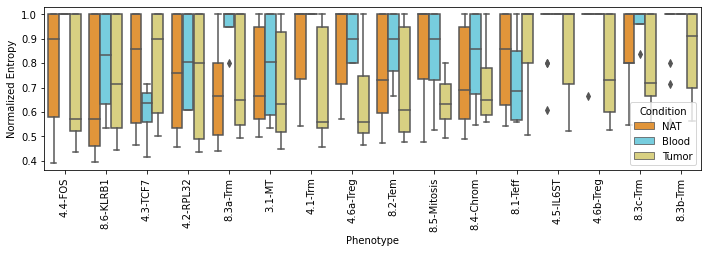

In [140]:
df = plot_phenotypic_entropy(adata)

In [19]:
def calc_entropy(P, log_units = 2):
    P = P[P>0].flatten()
    return numpy.dot(P, -numpy.log(P))/numpy.log(log_units)
def phenotypic_entropy(adata, phenotype):
    clonotype_dist = collections.defaultdict(list)
    for ct, clonotype in zip(adata.obs[adata.uns["phenotype_column"]], adata.obs["IR_VDJ_1_junction_aa"]):
        if ct == phenotype:
            prob = 1.0
        else:
            prob = 0.0
        clonotype_dist[clonotype].append(prob)
    clonotype_expected_cells = dict()
    total_sum = 0
    for clone, ps in clonotype_dist.items():
        clonotype_expected_cells[clone] = sum(ps)
        total_sum += sum(ps)
    phenotype_entropy = []
    for clone, psum in clonotype_expected_cells.items():
        phenotype_entropy.append(psum/total_sum)
    return calc_entropy(numpy.array(phenotype_entropy))  / numpy.log2(total_sum)

def plot_phenotypic_entropy(adata):
    entropies = []
    phenotypes = []
    conditions = []
    samples = []
    for c in set(adata.obs[adata.uns["condition_column"]]): 
        sub = adata[adata.obs[adata.uns["condition_column"]]==c]
        for s in set(sub.obs[sub.uns["sample_column"]]):
            cdata = sub[sub.obs[sub.uns["sample_column"]]==s]
            for ph in set(cdata.obs[sub.uns["phenotype_column"]]):
                ent = phenotypic_entropy(cdata, ph)
                entropies.append(ent)
                phenotypes.append(ph)
                conditions.append(c)
                samples.append(s)
    df = pandas.DataFrame.from_dict({"Sample":samples,
                                     "Condition":conditions,
                                     "Phenotype":phenotypes,
                                     "Normalized Entropy":entropies})
    df = df.sort_values("Normalized Entropy")
    fig, ax = plt.subplots(1,1,figsize=(10,5))
    sns.boxplot(data=df,x="Phenotype",y="Normalized Entropy",hue="Condition",ax=ax)
    plt.tight_layout()
    ax.set_xticklabels(ax.get_xticklabels(),rotation=90)

/var/folders/38/rslqw81d2rx5jfmt2pc_dmnhd336fz/T/ipykernel_4862/18555034.py:20: RuntimeWarning: invalid value encountered in double_scalars
  return calc_entropy(numpy.array(phenotype_entropy))  / numpy.log2(total_sum)


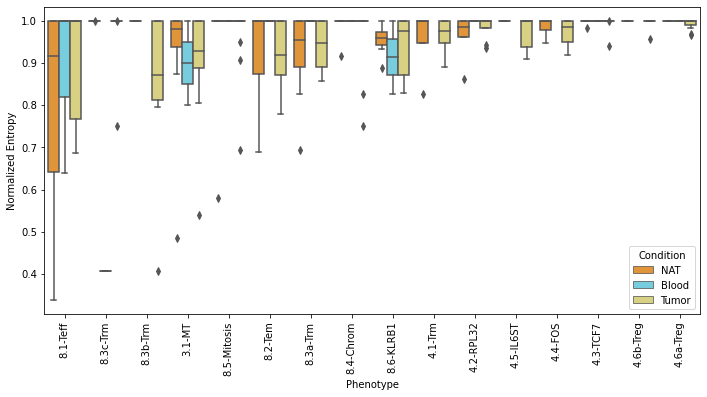

In [20]:
df = plot_phenotypic_entropy(adata)